In [1]:
from py123d.datatypes.scene.arrow.arrow_scene_builder import ArrowSceneBuilder
from py123d.datatypes.scene.scene_filter import SceneFilter

from py123d.common.multithreading.worker_sequential import Sequential
from py123d.datatypes.sensors.camera.pinhole_camera import PinholeCameraType 

Dataset paths not set. Using default config: /home/daniel/py123d_workspace/py123d/src/py123d/script/config/common/default_dataset_paths.yaml


In [2]:
from py123d.geometry import Point2D
import numpy as np

# import torch

from py123d.geometry.polyline import Polyline2D

In [3]:

# splits = ["wopd_val"]
# splits = ["carla"]
# splits = ["nuplan-mini_test"]
# splits = ["av2-sensor-mini_train"]
splits = ["pandaset_train"]
# log_names = None



log_names = None
scene_uuids = None

scene_filter = SceneFilter(
    split_names=splits,
    log_names=log_names,
    scene_uuids=scene_uuids,
    duration_s=6.0,
    history_s=0.0,
    timestamp_threshold_s=20,
    shuffle=True,
    # camera_types=[CameraType.CAM_F0],
)
scene_builder = ArrowSceneBuilder()
worker = Sequential()
# worker = RayDistributed()
scenes = scene_builder.get_scenes(scene_filter, worker)

print(f"Found {len(scenes)} scenes")

Found 82 scenes


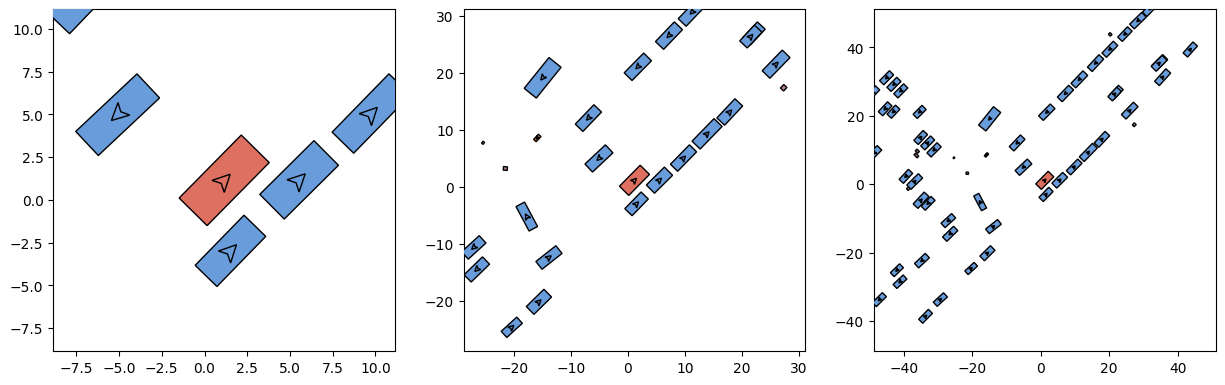

In [4]:
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np

from py123d.geometry import Point2D
from py123d.visualization.color.color import BLACK, DARK_GREY, DARKER_GREY, LIGHT_GREY, NEW_TAB_10, TAB_10
from py123d.visualization.color.config import PlotConfig
from py123d.visualization.color.default import CENTERLINE_CONFIG, MAP_SURFACE_CONFIG, ROUTE_CONFIG
from py123d.visualization.matplotlib.observation import (
    add_box_detections_to_ax,
    add_default_map_on_ax,
    add_ego_vehicle_to_ax,
    add_traffic_lights_to_ax,
)
from py123d.visualization.matplotlib.utils import add_shapely_linestring_to_ax, add_shapely_polygon_to_ax
from py123d.datatypes.maps.abstract_map import AbstractMap
from py123d.datatypes.maps.abstract_map_objects import AbstractLane, AbstractLaneGroup
from py123d.datatypes.maps.gpkg.gpkg_map_objects import GPKGIntersection
from py123d.datatypes.maps.map_datatypes import MapLayer
from py123d.datatypes.scene.abstract_scene import AbstractScene


import shapely.geometry as geom

LEFT_CONFIG: PlotConfig = PlotConfig(
    fill_color=TAB_10[2],
    fill_color_alpha=1.0,
    line_color=TAB_10[2],
    line_color_alpha=0.5,
    line_width=1.0,
    line_style="-",
    zorder=3,
)

RIGHT_CONFIG: PlotConfig = PlotConfig(
    fill_color=TAB_10[3],
    fill_color_alpha=1.0,
    line_color=TAB_10[3],
    line_color_alpha=0.5,
    line_width=1.0,
    line_style="-",
    zorder=22,
)


LANE_CONFIG: PlotConfig = PlotConfig(
    fill_color=BLACK,
    fill_color_alpha=1.0,
    line_color=BLACK,
    line_color_alpha=0.0,
    line_width=0.0,
    line_style="-",
    zorder=5,
)

ROAD_EDGE_CONFIG: PlotConfig = PlotConfig(
    fill_color=DARKER_GREY.set_brightness(0.0),
    fill_color_alpha=1.0,
    line_color=DARKER_GREY.set_brightness(0.0),
    line_color_alpha=1.0,
    line_width=1.0,
    line_style="-",
    zorder=3,
)

ROAD_LINE_CONFIG: PlotConfig = PlotConfig(
    fill_color=NEW_TAB_10[5],
    fill_color_alpha=1.0,
    line_color=NEW_TAB_10[5],
    line_color_alpha=1.0,
    line_width=1.5,
    line_style="-",
    zorder=3,
)


def add_debug_map_on_ax(
    ax: plt.Axes,
    map_api: AbstractMap,
    point_2d: Point2D,
    radius: float,
    route_lane_group_ids: Optional[List[int]] = None,
) -> None:
    layers: List[MapLayer] = [
        MapLayer.LANE,
        MapLayer.LANE_GROUP,
        MapLayer.GENERIC_DRIVABLE,
        MapLayer.CARPARK,
        MapLayer.CROSSWALK,
        MapLayer.INTERSECTION,
        MapLayer.WALKWAY,
        MapLayer.ROAD_EDGE,
        # MapLayer.ROAD_LINE,
    ]
    x_min, x_max = point_2d.x - radius, point_2d.x + radius
    y_min, y_max = point_2d.y - radius, point_2d.y + radius
    patch = geom.box(x_min, y_min, x_max, y_max)
    map_objects_dict = map_api.query(geometry=patch, layers=layers, predicate="intersects")

    done = False
    for layer, map_objects in map_objects_dict.items():
        for map_object in map_objects:
            try:
                if layer in [
                    MapLayer.GENERIC_DRIVABLE,
                    MapLayer.CARPARK,
                    MapLayer.CROSSWALK,
                    MapLayer.INTERSECTION,
                    MapLayer.WALKWAY,
                ]:
                    add_shapely_polygon_to_ax(ax, map_object.shapely_polygon, MAP_SURFACE_CONFIG[layer])

                if layer in [MapLayer.LANE_GROUP]:
                    map_object: AbstractLaneGroup
                    add_shapely_polygon_to_ax(ax, map_object.shapely_polygon, MAP_SURFACE_CONFIG[layer])

                if layer in [MapLayer.LANE]:
                    add_shapely_linestring_to_ax(ax, map_object.centerline.linestring, CENTERLINE_CONFIG)

                # if layer in [MapLayer.ROAD_EDGE]:
                #     add_shapely_linestring_to_ax(ax, map_object.polyline_3d.linestring, ROAD_EDGE_CONFIG)

                # if layer in [MapLayer.ROAD_LINE]:
                #     # line_type = int(map_object.road_line_type)
                #     # plt_config = PlotConfig(
                #     #     fill_color=NEW_TAB_10[line_type % (len(NEW_TAB_10) - 1)],
                #     #     fill_color_alpha=1.0,
                #     #     line_color=NEW_TAB_10[line_type % (len(NEW_TAB_10) - 1)],
                #     #     line_color_alpha=1.0,
                #     #     line_width=1.5,
                #     #     line_style="-",
                #     #     zorder=10,
                #     # )
                #     add_shapely_linestring_to_ax(ax, map_object.polyline_3d.linestring, ROAD_LINE_CONFIG)

            except Exception:
                import traceback

                print(f"Error adding map object of type {layer.name} and id {map_object.id}")
                traceback.print_exc()

    ax.set_title(f"Map: {map_api.map_name}")


def _plot_scene_on_ax(ax: plt.Axes, scene: AbstractScene, iteration: int = 0, radius: float = 80) -> plt.Axes:

    ego_vehicle_state = scene.get_ego_state_at_iteration(iteration)
    box_detections = scene.get_box_detections_at_iteration(iteration)
    map_api = scene.get_map_api()

    point_2d = ego_vehicle_state.bounding_box.center.state_se2.point_2d
    # add_debug_map_on_ax(ax, scene.get_map_api(), point_2d, radius=radius, route_lane_group_ids=None)
    if map_api is not None:
        add_default_map_on_ax(ax, map_api, point_2d, radius=radius, route_lane_group_ids=None)
    # add_traffic_lights_to_ax(ax, traffic_light_detections, scene.get_map_api())

    add_box_detections_to_ax(ax, box_detections)
    add_ego_vehicle_to_ax(ax, ego_vehicle_state)

    zoom = 1.0
    ax.set_xlim(point_2d.x - radius * zoom, point_2d.x + radius * zoom)
    ax.set_ylim(point_2d.y - radius * zoom, point_2d.y + radius * zoom)

    ax.set_aspect("equal", adjustable="box")
    return ax


def plot_scene_at_iteration(
    scene: AbstractScene, iteration: int = 0, radius: float = 80
) -> Tuple[plt.Figure, plt.Axes]:

    size = 10

    fig, ax = plt.subplots(figsize=(size, size))
    _plot_scene_on_ax(ax, scene, iteration, radius)
    return fig, ax


# scene_index = 
iteration = 1

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
scene = np.random.choice(scenes)
_plot_scene_on_ax(ax[0], scene, iteration, radius=10)
_plot_scene_on_ax(ax[1], scene, iteration, radius=30)
_plot_scene_on_ax(ax[2], scene, iteration, radius=50)

plt.show()


In [ ]:
scene_index = 17
iteration = 99

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
scene = scenes[scene_index]
_plot_scene_on_ax(ax[0], scene, iteration, radius=20)
_plot_scene_on_ax(ax[1], scene, iteration, radius=50)
_plot_scene_on_ax(ax[2], scene, iteration, radius=100)

plt.show()

In [ ]:
from py123d.dataset.conversion.map.road_edge.road_edge_2d_utils import get_road_edge_linear_rings
from py123d.dataset.maps.gpkg.gpkg_map import GPKGMap


map_api: GPKGMap = scenes[scene_index].map_api

drivable_polygons = map_api._gpd_dataframes[MapLayer.LANE]



linear_rings = get_road_edge_linear_rings(drivable_polygons.geometry.tolist())
rings_lengths = [ring.length for ring in linear_rings]
max_length_idx = np.argmax(rings_lengths)






size = 16
fig, ax = plt.subplots(figsize=(size, size))

for idx, ring in enumerate(linear_rings):
    if idx == max_length_idx:
        ax.plot(*ring.xy, color="black", linewidth=2, label="Longest Road Edge")
    else:
        ax.plot(*ring.xy)


ax.set_aspect("equal", adjustable="box")